# Interview Task

Running a Spark NLP Healthcare Pipeline and Training a Custom NER Model


## Objective

The goal of this task is to work with Spark NLP for Healthcare and run a Named Entity Recognition (NER) pipeline using provided pre-trained models (ner_clinical and ner_posology) on a public dataset. After generating predictions, you will create a CoNLL file from the predictions and use it to train a custom NER model.


## Dataset Selection

I chose [mtsamples](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/data/mtsamples_classifier.csv)  as a publicly available healthcare-related dataset.

## Set Up Spark NLP for Healthcare

In [1]:
import json
import os

from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

Saving spark_nlp_for_healthcare_spark_ocr_9680.json to spark_nlp_for_healthcare_spark_ocr_9680.json


In [2]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.4.1 spark-nlp==$PUBLIC_VERSION


# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.8/620.8 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.5/520.5 kB 624.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.1 MB/s eta 0:00:00


In [3]:
import json
import os

import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp_jsl.pipeline_tracer import PipelineTracer
from sparknlp_jsl.pipeline_output_parser import PipelineOutputParser

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline,PipelineModel

import pandas as pd
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.driver.maxResultSize":"2000M"}

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

spark

Spark NLP Version : 5.5.0
Spark NLP_JSL Version : 5.5.0


## NER Pipeline Execution

### Load the Dataset

In [4]:
# I will save some files to drive so I imported the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load the mtsamples dataset
data = spark.read.csv('/content/drive/MyDrive/SPARK-NLP/TASK/mtsamples_classifier.csv', header=True)


data.show(truncate=100)


+----------------+----------------------------------------------------------------------------------------------------+
|        category|                                                                                                text|
+----------------+----------------------------------------------------------------------------------------------------+
|Gastroenterology| PROCEDURES PERFORMED: Colonoscopy. INDICATIONS: Renewed symptoms likely consistent with active f...|
|Gastroenterology| OPERATION 1. Ivor-Lewis esophagogastrectomy. 2. Feeding jejunostomy. 3. Placement of two right-s...|
|Gastroenterology| PREOPERATIVE DIAGNOSES: 1. Gastroesophageal reflux disease. 2. Chronic dyspepsia. POSTOPERATIVE ...|
|Gastroenterology| PROCEDURE: Colonoscopy. PREOPERATIVE DIAGNOSES: Rectal bleeding and perirectal abscess. POSTOPER...|
|Gastroenterology| PREOPERATIVE DIAGNOSIS: Right colon tumor. POSTOPERATIVE DIAGNOSES: 1. Right colon cancer. 2. As...|
|Gastroenterology| PREOPERATIVE DIAGNOSI

In [ ]:
from pyspark.sql.functions import count, col

# Group by the 'category' column and count the occurrences of each category
category_counts = data.groupBy("category").agg(count("*").alias("counts"))

# Show the result
category_counts.show()

+----------------+------+
|        category|counts|
+----------------+------+
|         Urology|   115|
|       Neurology|   143|
|      Orthopedic|   223|
|Gastroenterology|   157|
+----------------+------+



### Create the Pipeline Components

This setup is designed to preprocess clinical text data for Named Entity Recognition (NER) in healthcare applications. It utilizes a structured NLP pipeline with modules for document assembly, sentence detection, tokenization, word embeddings, and entity recognition. The pipeline loads pre-trained models to identify general clinical entities and dosage-related terms. Each stage in the pipeline builds upon the previous one, ensuring that the text is incrementally transformed into a format suitable for extracting medically relevant information. This approach is efficient for healthcare-focused NLP tasks, allowing for both scalability and precision in entity extraction and recognition.

In [ ]:
# Document Assembler
document_assembler = DocumentAssembler() \
    .setInputCol('text') \
    .setOutputCol('document')

# Sentence Detector
sentence_detector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(['document']) \
    .setOutputCol('sentence')

# Tokenizer
tokenizer = Tokenizer() \
    .setInputCols(['sentence']) \
    .setOutputCol('token')

# Word Embeddings
word_embeddings = WordEmbeddingsModel.pretrained('embeddings_clinical', 'en', 'clinical/models') \
    .setInputCols(['sentence', 'token']) \
    .setOutputCol('embeddings')

# NER Clinical Model
ner_clinical = MedicalNerModel.pretrained('ner_clinical', 'en', 'clinical/models') \
    .setInputCols(['sentence', 'token', 'embeddings']) \
    .setOutputCol('ner_clinical')

# NER Posology Model
ner_posology = MedicalNerModel.pretrained('ner_posology', 'en', 'clinical/models') \
    .setInputCols(['sentence', 'token', 'embeddings']) \
    .setOutputCol('ner_posology')

# NER Converters
ner_converter_clinical = NerConverterInternal() \
    .setInputCols(['sentence', 'token', 'ner_clinical']) \
    .setOutputCol('entities_clinical')

ner_converter_posology = NerConverterInternal() \
    .setInputCols(['sentence', 'token', 'ner_posology']) \
    .setOutputCol('entities_posology')


sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
[OK!]
ner_posology download started this may take some time.
[OK!]


### Merge NER Outputs and Prioritize Posology

The ChunkMergeApproach combines entities identified in both clinical and posology NER outputs, prioritizing overlaps for a clean, consolidated result.

If we set setSelectionStrategy("Sequential") parameter, the chunk on the leftmost, entities_posology,  side will be prioritized in case of overlapping.

In [ ]:
chunk_merger = ChunkMergeApproach() \
    .setInputCols(['entities_posology', 'entities_clinical']) \
    .setOutputCol('merged_entities') \
    .setMergeOverlapping(True) \
    .setSelectionStrategy("Sequential")\
    .setCaseSensitive(False)


## Build the Pipeline

This segment finalizes the NER processing pipeline by assembling each component in sequence, then fitting it on an empty dataset to prepare the model for future inference.

In [ ]:
pipeline = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer,
    word_embeddings,
    ner_clinical,
    ner_posology,
    ner_converter_clinical,
    ner_converter_posology,
    chunk_merger
])


empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)

In [ ]:
data.show(truncate=100)

+----------------+----------------------------------------------------------------------------------------------------+
|        category|                                                                                                text|
+----------------+----------------------------------------------------------------------------------------------------+
|Gastroenterology| PROCEDURES PERFORMED: Colonoscopy. INDICATIONS: Renewed symptoms likely consistent with active f...|
|Gastroenterology| OPERATION 1. Ivor-Lewis esophagogastrectomy. 2. Feeding jejunostomy. 3. Placement of two right-s...|
|Gastroenterology| PREOPERATIVE DIAGNOSES: 1. Gastroesophageal reflux disease. 2. Chronic dyspepsia. POSTOPERATIVE ...|
|Gastroenterology| PROCEDURE: Colonoscopy. PREOPERATIVE DIAGNOSES: Rectal bleeding and perirectal abscess. POSTOPER...|
|Gastroenterology| PREOPERATIVE DIAGNOSIS: Right colon tumor. POSTOPERATIVE DIAGNOSES: 1. Right colon cancer. 2. As...|
|Gastroenterology| PREOPERATIVE DIAGNOSI

In [ ]:
#This step applies the trained NER pipeline model to new data,
#transforming it to extract and process entities as defined in the pipeline
merged_data = model.transform(data).cache()


## Extract and Review Entities in a Readable Format

In [ ]:
merged_data.show(10, truncate=500)

+----------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#a quick inspection of the tokenized text alongside detected dosage-related entities
%%time

merged_data.select('token.result','ner_posology.result').show(truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                              result|                                                                                              result|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|[PROCEDURES, PERFORMED, :, Colonoscopy, ., INDICATIONS, :, Renewed, symptoms, likely, consistent,...|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-DRUG, O, B-DRUG, O,...|
|[OPERATION, 1, ., Ivor-Lewis, esophagogastrectomy, ., 2, ., Feeding, jejunostomy, ., 3, ., Placem...|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, 

In [ ]:
#validating the clinical entity recognition output and verifying that tokens and entities align correctly in the results.
%%time

merged_data.select('token.result','ner_clinical.result').show(truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                              result|                                                                                              result|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|[PROCEDURES, PERFORMED, :, Colonoscopy, ., INDICATIONS, :, Renewed, symptoms, likely, consistent,...|[O, O, O, B-TEST, O, O, O, B-PROBLEM, I-PROBLEM, O, O, O, O, O, O, B-PROBLEM, I-PROBLEM, I-PROBLE...|
|[OPERATION, 1, ., Ivor-Lewis, esophagogastrectomy, ., 2, ., Feeding, jejunostomy, ., 3, ., Placem...|[B-PROBLEM, I-PROBLEM, O, B-TREATMENT, I-TREATMENT, O, O, O, B-TREATMENT, I-TREATM

In [ ]:
# extracting clinical entities from the merged data and formats them into a structured DataFrame with detailed entity information

df_clinical = merged_data.withColumn("id", F.monotonically_increasing_id()) \
                       .select('id',F.explode('entities_clinical').alias("cols")) \
                       .select('id',F.expr("cols.begin").alias("begin"),
                               F.expr("cols.end").alias("end"),
                               F.expr("cols.result").alias("chunk"),
                               F.expr("cols.metadata.entity").alias("entity"))

df_clinical.show(50, truncate=100)

+---+-----+----+------------------------------------------+---------+
| id|begin| end|                                     chunk|   entity|
+---+-----+----+------------------------------------------+---------+
|  0|   23|  33|                               Colonoscopy|     TEST|
|  0|   49|  64|                          Renewed symptoms|  PROBLEM|
|  0|  105| 130|                Inflammatory Bowel Disease|  PROBLEM|
|  0|  151| 170|                      conventional therapy|TREATMENT|
|  0|  182| 194|                             sulfasalazine|TREATMENT|
|  0|  197| 205|                                 cortisone|TREATMENT|
|  0|  208| 220|                             local therapy|TREATMENT|
|  0|  273| 285|                             the procedure|TREATMENT|
|  0|  363| 370|                                  bleeding|  PROBLEM|
|  0|  373| 381|                                 infection|  PROBLEM|
|  0|  384| 400|                         bowel perforation|  PROBLEM|
|  0|  403| 422|    

In [ ]:
# extracting posology entities from the merged data and formats them into a structured DataFrame with detailed entity information

df_posology = merged_data.withColumn("id", F.monotonically_increasing_id()) \
                       .select('id',F.explode('entities_posology').alias("cols")) \
                       .select('id',F.expr("cols.begin").alias("begin"),
                               F.expr("cols.end").alias("end"),
                               F.expr("cols.result").alias("chunk"),
                               F.expr("cols.metadata.entity").alias("entity"))

df_posology.show(50, truncate=100)

+---+-----+----+-----------------------------+---------+
| id|begin| end|                        chunk|   entity|
+---+-----+----+-----------------------------+---------+
|  0|  182| 194|                sulfasalazine|     DRUG|
|  0|  197| 205|                    cortisone|     DRUG|
|  0|  208| 212|                        local|     DRUG|
|  0|  551| 552|                           O2|     DRUG|
|  0|  817| 829|                sulfasalazine|     DRUG|
|  0|  920| 926|                      steroid|     DRUG|
|  0|  928| 932|                        taper|   DOSAGE|
|  0| 2808|2814|                      steroid|     DRUG|
|  0| 2816|2820|                        taper|   DOSAGE|
|  0| 2860|2867|                     steroids|     DRUG|
|  0| 2922|2950|immune suppressive medication|     DRUG|
|  0| 2961|2972|                 azathioprine|     DRUG|
|  1|  459| 468|                   anesthesia|     DRUG|
|  1|  523| 532|                   anesthesia|     DRUG|
|  2|  636| 641|               

In [ ]:
# to structure all entities (both clinical and posology) into a single DataFrame

df_merged = merged_data.withColumn("id", F.monotonically_increasing_id()) \
                       .select('id',F.explode('merged_entities').alias("cols")) \
                       .select('id',F.expr("cols.begin").alias("begin"),
                               F.expr("cols.end").alias("end"),
                               F.expr("cols.result").alias("chunk"),
                               F.expr("cols.metadata.entity").alias("entity"))

df_merged.show(50, truncate=100)

+---+-----+----+------------------------------------------+---------+
| id|begin| end|                                     chunk|   entity|
+---+-----+----+------------------------------------------+---------+
|  0|   23|  33|                               Colonoscopy|     TEST|
|  0|   49|  64|                          Renewed symptoms|  PROBLEM|
|  0|  105| 130|                Inflammatory Bowel Disease|  PROBLEM|
|  0|  151| 170|                      conventional therapy|TREATMENT|
|  0|  182| 194|                             sulfasalazine|     DRUG|
|  0|  197| 205|                                 cortisone|     DRUG|
|  0|  208| 212|                                     local|     DRUG|
|  0|  273| 285|                             the procedure|TREATMENT|
|  0|  363| 370|                                  bleeding|  PROBLEM|
|  0|  373| 381|                                 infection|  PROBLEM|
|  0|  384| 400|                         bowel perforation|  PROBLEM|
|  0|  403| 422|    

In [ ]:
merged_data.printSchema()

root
 |-- category: string (nullable = true)
 |-- text: string (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- sentence: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |--

In [ ]:
# raw text along with merged, clinical, and posology entities in a single DataFrame
entities_df = merged_data.select('text', 'merged_entities',"entities_clinical","entities_posology")
entities_df.show(30, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# clinical NER results to create a DataFrame showing tokens, their corresponding NER labels, and confidence scores.

ner_label_clinical = merged_data.select(F.explode(F.arrays_zip(merged_data.token.result,
                                                 merged_data.ner_clinical.result,
                                                 merged_data.ner_clinical.metadata)).alias("cols"))\
                  .select(F.expr("cols['0']").alias("token"),
                          F.expr("cols['1']").alias("ner_label"),
                          F.expr("cols['2']['confidence']").alias("confidence"))

ner_label_clinical.show(50, truncate=100)

+-------------+-----------+----------+
|        token|  ner_label|confidence|
+-------------+-----------+----------+
|   PROCEDURES|          O|    0.9935|
|    PERFORMED|          O|    0.8066|
|            :|          O|    0.9997|
|  Colonoscopy|     B-TEST|    0.9815|
|            .|          O|       1.0|
|  INDICATIONS|          O|    0.7565|
|            :|          O|       1.0|
|      Renewed|  B-PROBLEM|    0.7681|
|     symptoms|  I-PROBLEM|    0.9892|
|       likely|          O|    0.9998|
|   consistent|          O|    0.9517|
|         with|          O|    0.9996|
|       active|          O|    0.7112|
|        flare|          O|    0.7733|
|           of|          O|    0.9558|
| Inflammatory|  B-PROBLEM|    0.6967|
|        Bowel|  I-PROBLEM|    0.9305|
|      Disease|  I-PROBLEM|    0.9948|
|            ,|          O|       1.0|
|          not|          O|    0.9755|
|   responsive|          O|    0.7764|
|           to|          O|    0.9968|
| conventional|B-TREATMEN

In [ ]:
# posology NER results to create a DataFrame showing tokens, their corresponding NER labels, and confidence scores.

ner_label_posology = merged_data.select(F.explode(F.arrays_zip(merged_data.token.result,
                                                 merged_data.ner_posology.result,
                                                 merged_data.ner_posology.metadata)).alias("cols"))\
                  .select(F.expr("cols['0']").alias("token"),
                          F.expr("cols['1']").alias("ner_label"),
                          F.expr("cols['2']['confidence']").alias("confidence"))

ner_label_posology.show(50, truncate=100)

+-------------+---------+----------+
|        token|ner_label|confidence|
+-------------+---------+----------+
|   PROCEDURES|        O|    0.9993|
|    PERFORMED|        O|    0.8019|
|            :|        O|    0.9795|
|  Colonoscopy|        O|    0.7328|
|            .|        O|    0.9889|
|  INDICATIONS|        O|    0.9998|
|            :|        O|    0.9964|
|      Renewed|        O|    0.9941|
|     symptoms|        O|    0.9843|
|       likely|        O|    0.9924|
|   consistent|        O|    0.9852|
|         with|        O|    0.9948|
|       active|        O|    0.9615|
|        flare|        O|    0.9729|
|           of|        O|    0.9783|
| Inflammatory|        O|    0.9996|
|        Bowel|        O|    0.9934|
|      Disease|        O|    0.9179|
|            ,|        O|    0.9948|
|          not|        O|     0.998|
|   responsive|        O|     0.992|
|           to|        O|    0.9891|
| conventional|        O|    0.9224|
|      therapy|        O|     0.941|
|

In [ ]:
# grouping the extracted tokens by their NER clinical label and counts the occurrences of each label.

ner_label_clinical.select("token", "ner_label")\
         .groupBy('ner_label').count()\
         .orderBy('count', ascending=False)\
         .show(truncate=False)

+-----------+------+
|ner_label  |count |
+-----------+------+
|O          |279620|
|I-PROBLEM  |31321 |
|B-PROBLEM  |18265 |
|I-TREATMENT|18098 |
|B-TREATMENT|13707 |
|I-TEST     |6673  |
|B-TEST     |5690  |
+-----------+------+



In [ ]:
# grouping the extracted tokens by their NER POSOLOGY label and counts the occurrences of each label.

ner_label_posology.select("token", "ner_label")\
         .groupBy('ner_label').count()\
         .orderBy('count', ascending=False)\
         .show(truncate=False)

+-----------+------+
|ner_label  |count |
+-----------+------+
|O          |366996|
|B-DRUG     |2941  |
|B-STRENGTH |660   |
|B-FREQUENCY|471   |
|I-STRENGTH |418   |
|B-ROUTE    |373   |
|I-DRUG     |365   |
|I-FREQUENCY|290   |
|B-DOSAGE   |246   |
|B-FORM     |206   |
|I-DOSAGE   |170   |
|I-DURATION |162   |
|B-DURATION |73    |
|I-ROUTE    |3     |
+-----------+------+



In [ ]:
# to structure all entities (both clinical and posology) into a single DataFrame

df_merged = merged_data.withColumn("id", F.monotonically_increasing_id()) \
                       .select('id',F.explode('merged_entities').alias("cols")) \
                       .select('id',F.expr("cols.begin").alias("begin"),
                               F.expr("cols.end").alias("end"),
                               F.expr("cols.result").alias("chunk"),
                               F.expr("cols.metadata.entity").alias("entity"))

df_merged.show(50, truncate=100)

+---+-----+----+------------------------------------------+---------+
| id|begin| end|                                     chunk|   entity|
+---+-----+----+------------------------------------------+---------+
|  0|   23|  33|                               Colonoscopy|     TEST|
|  0|   49|  64|                          Renewed symptoms|  PROBLEM|
|  0|  105| 130|                Inflammatory Bowel Disease|  PROBLEM|
|  0|  151| 170|                      conventional therapy|TREATMENT|
|  0|  182| 194|                             sulfasalazine|     DRUG|
|  0|  197| 205|                                 cortisone|     DRUG|
|  0|  208| 212|                                     local|     DRUG|
|  0|  273| 285|                             the procedure|TREATMENT|
|  0|  363| 370|                                  bleeding|  PROBLEM|
|  0|  373| 381|                                 infection|  PROBLEM|
|  0|  384| 400|                         bowel perforation|  PROBLEM|
|  0|  403| 422|    

In [ ]:
# Exports the DataFrame as a CSV file to Google Drive
df_merged.toPandas().to_csv("/content/drive/MyDrive/SPARK-NLP/TASK/ner_predictions.csv", index=False)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/SPARK-NLP/TASK/ner_predictions.csv")
df.head()

,id,begin,end,chunk,entity
0,0,23,33,Colonoscopy,TEST
1,0,49,64,Renewed symptoms,PROBLEM
2,0,105,130,Inflammatory Bowel Disease,PROBLEM
3,0,151,170,conventional therapy,TREATMENT
4,0,182,194,sulfasalazine,DRUG


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39691 entries, 0 to 39690
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      39691 non-null  int64 
 1   begin   39691 non-null  int64 
 2   end     39691 non-null  int64 
 3   chunk   39691 non-null  object
 4   entity  39691 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.5+ MB


## Generate CoNLL File:

In [ ]:
# renaming the columns in train_entities_df to standardized names, which is helpful for consistency and readability when handling training data.

train_entities_df= df
train_entities_df.columns = ["text_id","begin","end","chunk","entity"]
train_entities_df.head()

,text_id,begin,end,chunk,entity
0,0,23,33,Colonoscopy,TEST
1,0,49,64,Renewed symptoms,PROBLEM
2,0,105,130,Inflammatory Bowel Disease,PROBLEM
3,0,151,170,conventional therapy,TREATMENT
4,0,182,194,sulfasalazine,DRUG


In [ ]:
# loading a CSV file, processes it, and prepares a DataFrame specifically for training by
# assigning unique IDs to each text entry and removing unwanted columns.

train_text_df = pd.read_csv('/content/drive/MyDrive/SPARK-NLP/TASK/mtsamples_classifier.csv')

train_text_df["text_id"] = train_text_df.index
train_text_df = train_text_df.drop("category", axis=1)
train_text_df = train_text_df[["text_id", "text"]]
train_text_df.head()

,text_id,text
0,0,"PROCEDURES PERFORMED: Colonoscopy. INDICATIONS: Renewed symptoms likely consistent with active flare of Inflammatory Bowel Disease, not responsive to conventional therapy including sulfasalazine,..."
1,1,OPERATION 1. Ivor-Lewis esophagogastrectomy. 2. Feeding jejunostomy. 3. Placement of two right-sided #28-French chest tubes. 4. Right thoracotomy. ANESTHESIA: General endotracheal anesthesia with...
2,2,PREOPERATIVE DIAGNOSES: 1. Gastroesophageal reflux disease. 2. Chronic dyspepsia. POSTOPERATIVE DIAGNOSES: 1. Gastroesophageal reflux disease. 2. Chronic dyspepsia. 3. Alkaline reflux gastritis. ...
3,3,PROCEDURE: Colonoscopy. PREOPERATIVE DIAGNOSES: Rectal bleeding and perirectal abscess. POSTOPERATIVE DIAGNOSIS: Perianal abscess. MEDICATIONS: MAC. DESCRIPTION OF PROCEDURE: The Olympus pediatri...
4,4,PREOPERATIVE DIAGNOSIS: Right colon tumor. POSTOPERATIVE DIAGNOSES: 1. Right colon cancer. 2. Ascites. 3. Adhesions. PROCEDURE PERFORMED: 1. Exploratory laparotomy. 2. Lysis of adhesions. 3. Righ...


In [ ]:
spark_df = spark.createDataFrame(train_text_df)
spark_df.show()

+-------+--------------------+
|text_id|                text|
+-------+--------------------+
|      0| PROCEDURES PERFO...|
|      1| OPERATION 1. Ivo...|
|      2| PREOPERATIVE DIA...|
|      3| PROCEDURE: Colon...|
|      4| PREOPERATIVE DIA...|
|      5| PREOPERATIVE DIA...|
|      6| The patient was ...|
|      7| PREOPERATIVE DIA...|
|      8| PREOPERATIVE DIA...|
|      9| HISTORY OF PRESE...|
|     10| PREOPERATIVE DIA...|
|     11| PREOPERATIVE DIA...|
|     12| PROCEDURE IN DET...|
|     13| PREPROCEDURE DIA...|
|     14| The patient is a...|
|     15| DIAGNOSIS ON ADM...|
|     16| EXAM: CT abdomen...|
|     17| Sample Doctor, M...|
|     18| CHIEF COMPLAINT:...|
|     19| PREOPERATIVE DIA...|
+-------+--------------------+
only showing top 20 rows



In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

nlpPipeline = Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer])

result = nlpPipeline.fit(spark_df).transform(spark_df)

In [ ]:
result.select("text_id",F.explode(F.arrays_zip(result.token.result,
                                            result.token.begin,
                                            result.token.end,
                                            result.token.metadata)).alias("cols"))\
                  .select("text_id",F.expr("cols['0']").alias("token"),
                          F.expr("cols['3']['sentence']").alias("sentence_id"),
                          F.expr("cols['1']").alias("token_begin"),
                          F.expr("cols['2']").alias("token_end")).show(50, truncate=100)

+-------+-------------+-----------+-----------+---------+
|text_id|        token|sentence_id|token_begin|token_end|
+-------+-------------+-----------+-----------+---------+
|      0|   PROCEDURES|          0|          1|       10|
|      0|    PERFORMED|          0|         12|       20|
|      0|            :|          0|         21|       21|
|      0|  Colonoscopy|          0|         23|       33|
|      0|            .|          0|         34|       34|
|      0|  INDICATIONS|          1|         36|       46|
|      0|            :|          1|         47|       47|
|      0|      Renewed|          1|         49|       55|
|      0|     symptoms|          1|         57|       64|
|      0|       likely|          1|         66|       71|
|      0|   consistent|          1|         73|       82|
|      0|         with|          1|         84|       87|
|      0|       active|          1|         89|       94|
|      0|        flare|          1|         96|      100|
|      0|     

In [ ]:
test_token_df=result.select("text_id",F.explode(F.arrays_zip(result.token.result,
                                            result.token.begin,
                                            result.token.end,
                                            result.token.metadata)).alias("cols"))\
                  .select("text_id",F.expr("cols['0']").alias("token"),
                          F.expr("cols['3']['sentence']").alias("sentence_id"),
                          F.expr("cols['1']").alias("begin"),
                          F.expr("cols['2']").alias("end")).toPandas()

In [ ]:
new_token_df = test_token_df.copy()
new_token_df["entity"] = "O"

inner_label=False
for i, token_row in test_token_df.iterrows():
    text_id = token_row.text_id
    token_begin = token_row.begin
    token_end = token_row.end


    for j, entity_row in train_entities_df[train_entities_df.text_id == text_id].iterrows():
        entity_begin = entity_row.begin
        entity_end = entity_row.end


        if (entity_begin<= token_begin) and (token_end<= entity_end):
            if new_token_df.loc[i-1,"entity"] == new_token_df.loc[i,"entity"] :
                new_token_df.loc[i,"entity"] = "B-"+(entity_row.entity)
            else:
                new_token_df.loc[i,"entity"] = "I-"+(entity_row.entity)

In [ ]:
new_token_df.to_csv("train_new_token_df.csv",index=False)

In [ ]:
new_token_df.to_csv("/content/drive/MyDrive/SPARK-NLP/TASK/train_new_token_df.csv",index=False)

In [ ]:
conll_text = "-DOCSTART- -X- -0- O\n\n"
sentence_index = 0
document_index = 0


for i, row in new_token_df.iterrows():
    if document_index == row.text_id:

        if sentence_index == row.sentence_id:
            conll_text += f"{row.token} NN NN {row.entity}\n"

        else:
            conll_text += "\n"
            sentence_index = row.sentence_id
            conll_text += f"{row.token} NN NN {row.entity}\n"

    else:
        document_index = row.text_id
        conll_text += f"\n-DOCSTART- -X- -{row.text_id}- O\n"
        conll_text += "\n"
        conll_text += f"{row.token} NN NN {row.entity}\n"
        sentence_index = row.sentence_id

In [ ]:
# Checking conll string
print(conll_text[:532])

-DOCSTART- -X- -0- O


PROCEDURES NN NN O
PERFORMED NN NN O
: NN NN O
Colonoscopy NN NN B-TEST
. NN NN O

INDICATIONS NN NN O
: NN NN O
Renewed NN NN B-PROBLEM
symptoms NN NN I-PROBLEM
likely NN NN O
consistent NN NN O
with NN NN O
active NN NN O
flare NN NN O
of NN NN O
Inflammatory NN NN B-PROBLEM
Bowel NN NN I-PROBLEM
Disease NN NN I-PROBLEM
, NN NN O
not NN NN O
responsive NN NN O
to NN NN O
conventional NN NN B-TREATMENT
therapy NN NN I-TREATMENT
including NN NN O
sulfasalazine NN NN B-DRUG
, NN NN O
cortisone NN NN B-DRU


### Saving CoNLL File

In [ ]:
with open("conll2003_text_file.conll", "w+", encoding='utf8') as f:
    f.write("-DOCSTART- -X- -X- O\n\n")
    f.write(conll_text)

In [ ]:
# save to drive
!cp conll2003_text_file.conll /content/drive/MyDrive/SPARK-NLP/TASK/conll2003_text_file.conll

### Reading CoNLL File by Using CoNLL Reader

In [6]:
from sparknlp.training import CoNLL
conll_data = CoNLL().readDataset(spark, "/content/drive/MyDrive/SPARK-NLP/TASK/conll2003_text_file.conll")
conll_data.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|PROCEDURES PERFOR...|[{document, 0, 35...|[{document, 0, 35...|[{token, 0, 9, PR...|[{pos, 0, 9, NN, ...|[{named_entity, 0...|
|INDICATIONS : Ren...|[{document, 0, 19...|[{document, 0, 19...|[{token, 0, 10, I...|[{pos, 0, 10, NN,...|[{named_entity, 0...|
|PROCEDURE : Infor...|[{document, 0, 12...|[{document, 0, 12...|[{token, 0, 8, PR...|[{pos, 0, 8, NN, ...|[{named_entity, 0...|
|Risks explained a...|[{document, 0, 11...|[{document, 0, 11...|[{token, 0, 4, Ri...|[{pos, 0, 4, NN, ...|[{named_entity, 0...|
|Vital signs were ...|[{document, 0, 82...|[{document, 0, 82...|[{token, 0, 4, Vi...|[{pos, 0, 4, NN, ..

In [7]:
conll_data.count()

25948

In [8]:
# analyze the distribution of NER tags

conll_data.select(F.explode(F.arrays_zip(conll_data.token.result,
                                         conll_data.label.result)).alias("cols")) \
          .select(F.expr("cols['0']").alias("token"),
                  F.expr("cols['1']").alias("ground_truth"))\
          .groupBy('ground_truth')\
          .count()\
          .orderBy('count', ascending=False)\
          .show(100,truncate=False)

+------------+------+
|ground_truth|count |
+------------+------+
|O           |277381|
|I-PROBLEM   |31442 |
|B-PROBLEM   |18210 |
|I-TREATMENT |17311 |
|B-TREATMENT |11387 |
|I-TEST      |6658  |
|B-TEST      |5650  |
|B-DRUG      |2159  |
|I-STRENGTH  |850   |
|I-FREQUENCY |665   |
|I-DRUG      |575   |
|B-STRENGTH  |216   |
|I-DOSAGE    |213   |
|I-DURATION  |198   |
|B-DOSAGE    |188   |
|B-ROUTE     |169   |
|I-ROUTE     |165   |
|I-FORM      |162   |
|B-FREQUENCY |96    |
|B-DURATION  |37    |
|B-FORM      |20    |
+------------+------+



In [9]:
# total number of unique NER labels
conll_data.select("label.result").distinct().count()

11286

In [10]:
'''
As you can see, there are too many `O` labels in the dataset.
To make it more balanced, we can drop the sentences have only O labels.
(`c>1` means we drop all the sentences that have no valuable labels other than `O`)
'''


conll_data = conll_data.withColumn('unique', F.array_distinct("label.result"))\
                       .withColumn('c', F.size('unique'))\
                       .filter(F.col('c')>1)

conll_data.select(F.explode(F.arrays_zip(conll_data.token.result,conll_data.label.result)).alias("cols")) \
          .select(F.expr("cols['0']").alias("token"),
                  F.expr("cols['1']").alias("ground_truth"))\
          .groupBy('ground_truth')\
          .count()\
          .orderBy('count', ascending=False)\
          .show(100,truncate=False)


+------------+------+
|ground_truth|count |
+------------+------+
|O           |217232|
|I-PROBLEM   |31406 |
|B-PROBLEM   |18208 |
|I-TREATMENT |17311 |
|B-TREATMENT |11387 |
|I-TEST      |6654  |
|B-TEST      |5641  |
|B-DRUG      |2158  |
|I-STRENGTH  |850   |
|I-FREQUENCY |665   |
|I-DRUG      |575   |
|B-STRENGTH  |216   |
|I-DOSAGE    |213   |
|I-DURATION  |198   |
|B-DOSAGE    |188   |
|B-ROUTE     |169   |
|I-ROUTE     |165   |
|I-FORM      |162   |
|B-FREQUENCY |96    |
|B-DURATION  |37    |
|B-FORM      |20    |
+------------+------+



### Split the dataset into 80% training and 20% test set

In [11]:
(train_data, test_data) = conll_data.randomSplit([0.8, 0.2], seed=42)

In [12]:
# Verify the splits
print(f"Training Data Count: {train_data.count()}")
print(f"Test Data Count: {test_data.count()}")

Training Data Count: 15951
Test Data Count: 3824


In [13]:
# Optionally, show a sample of each split
print("Training Data Sample:")
train_data.show(5, truncate=False)

Training Data Sample:
+------------------------------------------------+---------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [14]:
print("Test Data Sample:")
test_data.show(5, truncate=False)

Test Data Sample:
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Custom NER Model Training:


### Clinical word embeddings trained on PubMED dataset

In [15]:
clinical_embeddings = WordEmbeddingsModel.pretrained('embeddings_clinical', "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


### Split the test data into two parts:
- We Keep the first part separate and use it for training the model further, as it will be totally unseen data from the same taxonomy.

- The second part will be used to testing and evaluating

In [16]:
(test_data_1, test_data_2) = test_data.randomSplit([0.5, 0.5], seed = 100)

# save the test data as parquet for easy testing
clinical_embeddings.transform(test_data_1).write.mode("overwrite").parquet('test_1.parquet')

clinical_embeddings.transform(test_data_2).write.mode("overwrite").parquet('test_2.parquet')

### Create a graph

We will use TFGraphBuilder annotator which can be used to create graphs in the model training pipeline. TFGraphBuilder inspects the data and creates the proper graph if a suitable version of TensorFlow (<= 2.7 ) is available. The graph is stored in the defined folder and loaded by the approach.

In [17]:
!pip install -q tensorflow==2.12.0
!pip install -q tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 27.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
bigframes 1

In [18]:
from sparknlp_jsl.annotator import TFGraphBuilder

In [19]:
# Define the TFGraphBuilder , which is useful for training or deploying custom NER models.

graph_folder_path = "medical_ner_graphs"

ner_graph_builder = TFGraphBuilder()\
    .setModelName("ner_dl")\
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setLabelColumn("label")\
    .setGraphFolder(graph_folder_path)\
    .setGraphFile("auto")\
    .setHiddenUnitsNumber(128)\
    .setIsLicensed(True)

### Build NER Model

This pipeline is optimized for training an NER model in the medical domain, with detailed logging, confidence scores, and memory optimization. The use of early stopping, drop out and validation split makes it more efficient and less prone to overfitting.

In [20]:
nerTagger = MedicalNerApproach()\
      .setInputCols(["sentence", "token", "embeddings"])\
      .setLabelColumn("label")\
      .setOutputCol("ner")\
      .setMaxEpochs(20)\
      .setLr(0.003)\
      .setBatchSize(32)\
      .setRandomSeed(0)\
      .setVerbose(1)\
      .setEvaluationLogExtended(True) \
      .setEnableOutputLogs(True)\
      .setIncludeConfidence(True)\
      .setTestDataset('./test_2.parquet')\
      .setGraphFolder(graph_folder_path)\
      .setOutputLogsPath('./ner_logs')\
      .setValidationSplit(0.2)\
      .setEnableMemoryOptimizer(True)\
      .setDropout(0.5)\
      .setUseBestModel(True)\
      .setEarlyStoppingCriterion(0.04)\
      .setEarlyStoppingPatience(5)\

ner_pipeline = Pipeline(stages=[
      clinical_embeddings,
      ner_graph_builder,
      nerTagger
 ])

In [21]:
%%time
ner_model = ner_pipeline.fit(train_data)

TF Graph Builder configuration:
Model name: ner_dl
Graph folder: medical_ner_graphs
Graph file name: auto
Build params: {'ntags': 21, 'embeddings_dim': 200, 'nchars': 83, 'is_medical': True, 'lstm_size': 128}


Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


ner_dl graph exported to medical_ner_graphs/blstm_21_200_128_83.pb
CPU times: user 23.5 s, sys: 2.31 s, total: 25.8 s
Wall time: 36min 37s


In [22]:
# we will use for showing the loss and metrics
!ls ner_logs/MedicalNerApproach*

ner_logs/MedicalNerApproach_974ff3998dce.log


In [23]:
# Training Logs
! cat ner_logs/MedicalNerApproach*

Name of the selected graph: /content/medical_ner_graphs/blstm_21_200_128_83.pb
Training started - total epochs: 20 - lr: 0.003 - batch size: 32 - labels: 21 - chars: 82 - training examples: 15951


Epoch 1/20 started, lr: 0.003, dataset size: 15951


Epoch 1/20 - 116.20s - loss: 2479.1682 - avg training loss: 6.244756 - batches: 397
Quality on validation dataset (20.0%), validation examples = 3190
time to finish evaluation: 30.87s
Total validation loss: 290.7821	Avg validation loss: 2.8508
label	 tp	 fp	 fn	 prec	 rec	 f1
B-DRUG	 287	 36	 55	 0.8885449	 0.8391813	 0.8631579
B-STRENGTH	 15	 2	 19	 0.88235295	 0.44117647	 0.5882353
I-TREATMENT	 2232	 314	 595	 0.8766693	 0.78952956	 0.8308208
I-DURATION	 1	 0	 18	 1.0	 0.05263158	 0.099999994
I-PROBLEM	 4679	 1187	 703	 0.7976475	 0.8693794	 0.8319701
I-STRENGTH	 84	 24	 11	 0.7777778	 0.8842105	 0.82758623
B-PROBLEM	 2887	 523	 281	 0.8466276	 0.9113005	 0.87777436
I-FREQUENCY	 59	 21	 14	 0.7375	 0.8082192	 0.77124184
I-TEST	 766	 197	

### Evaluate

providing detailed insights into the model’s precision, recall, and F1-score per entity type, along with overall macro and micro F1-scores, giving you a comprehensive view of model performance while excluding non-entity labels on TEST_DATA_2.

In [24]:
from sparknlp_jsl.eval import NerDLMetrics
import pyspark.sql.functions as F

pred_df = ner_model.stages[2].transform(clinical_embeddings.transform(test_data_2))

evaler = NerDLMetrics(mode="full_chunk")

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label", drop_o = True, case_sensitive = True).cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
           .withColumn("recall", F.round(eval_result["recall"],4))\
           .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+---------+------+-----+-----+------+---------+------+------+
|   entity|    tp|   fp|   fn| total|precision|recall|    f1|
+---------+------+-----+-----+------+---------+------+------+
| DURATION|   8.0|  0.0|  6.0|  14.0|      1.0|0.5714|0.7273|
|  PROBLEM|1574.0|255.0|217.0|1791.0|   0.8606|0.8788|0.8696|
|     DRUG| 224.0| 19.0| 33.0| 257.0|   0.9218|0.8716| 0.896|
|   DOSAGE|  15.0|  4.0|  6.0|  21.0|   0.7895|0.7143|  0.75|
|TREATMENT| 960.0|205.0|148.0|1108.0|    0.824|0.8664|0.8447|
|    ROUTE|  37.0|  0.0|  4.0|  41.0|      1.0|0.9024|0.9487|
|FREQUENCY|  50.0|  9.0|  8.0|  58.0|   0.8475|0.8621|0.8547|
|     TEST| 502.0| 90.0| 83.0| 585.0|    0.848|0.8581| 0.853|
|     FORM|  12.0|  0.0|  5.0|  17.0|      1.0|0.7059|0.8276|
| STRENGTH|  90.0|  7.0|  2.0|  92.0|   0.9278|0.9783|0.9524|
+---------+------+-----+-----+------+---------+------+------+

+------------------+
|             macro|
+------------------+
|0.8523986728536972|
+------------------+

None
+------------------+

comprehensive view of model performance on TEST_DATA_1

In [25]:
pred_df = ner_model.stages[2].transform(clinical_embeddings.transform(test_data_1))

evaler = NerDLMetrics(mode="full_chunk")

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label", drop_o = True, case_sensitive = True).cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
           .withColumn("recall", F.round(eval_result["recall"],4))\
           .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+---------+------+-----+-----+------+---------+------+------+
|   entity|    tp|   fp|   fn| total|precision|recall|    f1|
+---------+------+-----+-----+------+---------+------+------+
| DURATION|   3.0|  1.0|  0.0|   3.0|     0.75|   1.0|0.8571|
|  PROBLEM|1512.0|239.0|205.0|1717.0|   0.8635|0.8806| 0.872|
|     DRUG| 194.0| 18.0| 26.0| 220.0|   0.9151|0.8818|0.8981|
|   DOSAGE|  15.0|  3.0|  6.0|  21.0|   0.8333|0.7143|0.7692|
|TREATMENT| 963.0|198.0|157.0|1120.0|   0.8295|0.8598|0.8444|
|    ROUTE|  23.0|  2.0|  3.0|  26.0|     0.92|0.8846| 0.902|
|FREQUENCY|  39.0|  8.0|  7.0|  46.0|   0.8298|0.8478|0.8387|
|     TEST| 462.0| 65.0| 66.0| 528.0|   0.8767| 0.875|0.8758|
|     FORM|   9.0|  0.0|  9.0|  18.0|      1.0|   0.5|0.6667|
| STRENGTH|  91.0|  4.0|  4.0|  95.0|   0.9579|0.9579|0.9579|
+---------+------+-----+-----+------+---------+------+------+

+-----------------+
|            macro|
+-----------------+
|0.848192184790744|
+-----------------+

None
+------------------+
|   

Evaluating the NER model using a different metric mode, partial_chunk_per_token, which evaluates each token within an entity chunk independently.

In [26]:
evaler = NerDLMetrics(mode="partial_chunk_per_token")

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label", drop_o = True, case_sensitive = True).cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
           .withColumn("recall", F.round(eval_result["recall"],4))\
           .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+---------+------+-----+-----+------+---------+------+------+
|   entity|    tp|   fp|   fn| total|precision|recall|    f1|
+---------+------+-----+-----+------+---------+------+------+
| DURATION|   8.0|  2.0|  0.0|   8.0|      0.8|   1.0|0.8889|
|  PROBLEM|4243.0|462.0|372.0|4615.0|   0.9018|0.9194|0.9105|
|     DRUG| 213.0| 15.0| 32.0| 245.0|   0.9342|0.8694|0.9006|
|   DOSAGE|  27.0|  4.0|  5.0|  32.0|    0.871|0.8438|0.8571|
|TREATMENT|2662.0|447.0|168.0|2830.0|   0.8562|0.9406|0.8964|
|    ROUTE|  23.0|  2.0|  3.0|  26.0|     0.92|0.8846| 0.902|
|FREQUENCY|  44.0| 10.0|  8.0|  52.0|   0.8148|0.8462|0.8302|
|     TEST|1081.0|129.0|124.0|1205.0|   0.8934|0.8971|0.8952|
|     FORM|   9.0|  0.0|  9.0|  18.0|      1.0|   0.5|0.6667|
| STRENGTH|  99.0|  4.0|  3.0| 102.0|   0.9612|0.9706|0.9659|
+---------+------+-----+-----+------+---------+------+------+

+------------------+
|             macro|
+------------------+
|0.8713536114298368|
+------------------+

None
+------------------+

In [27]:
# save the model
ner_model.stages[2].write().overwrite().save('/content/drive/MyDrive/SPARK-NLP/TASK/models/custom_NER_model')

In [28]:
ner_model.stages[2].write().overwrite().save('models/custom_NER')

### Now let's take a model trained on a different dataset and train on this dataset

We can compare our model metrics with below jsl_ner model

In [ ]:
jsl_ner = MedicalNerModel.pretrained('ner_jsl','en','clinical/models')

jsl_ner.getClasses()

ner_jsl download started this may take some time.
[OK!]


['O',
 'B-Injury_or_Poisoning',
 'B-Direction',
 'B-Test',
 'I-Route',
 'B-Admission_Discharge',
 'B-Death_Entity',
 'I-Oxygen_Therapy',
 'B-Relationship_Status',
 'I-Drug_BrandName',
 'B-Duration',
 'I-Alcohol',
 'I-Triglycerides',
 'I-Date',
 'B-Hyperlipidemia',
 'B-Respiration',
 'I-Test',
 'B-Birth_Entity',
 'I-VS_Finding',
 'B-Age',
 'I-Vaccine_Name',
 'I-Social_History_Header',
 'B-Labour_Delivery',
 'I-Medical_Device',
 'B-Family_History_Header',
 'B-BMI',
 'I-Fetus_NewBorn',
 'I-BMI',
 'B-Temperature',
 'I-Section_Header',
 'I-Communicable_Disease',
 'I-ImagingFindings',
 'I-Psychological_Condition',
 'I-Obesity',
 'I-Sexually_Active_or_Sexual_Orientation',
 'I-Modifier',
 'B-Alcohol',
 'I-Temperature',
 'I-Vaccine',
 'I-Symptom',
 'I-Pulse',
 'B-Kidney_Disease',
 'B-Oncological',
 'I-EKG_Findings',
 'B-Medical_History_Header',
 'I-Relationship_Status',
 'B-Cerebrovascular_Disease',
 'I-Blood_Pressure',
 'I-Diabetes',
 'B-Oxygen_Therapy',
 'B-O2_Saturation',
 'B-Psychological_C

## Now train a model using this model as base

In [ ]:
nerTaggerJsl = MedicalNerApproach()\
      .setInputCols(["sentence", "token", "embeddings"])\
      .setLabelColumn("label")\
      .setOutputCol("ner")\
      .setMaxEpochs(30)\
      .setLr(0.003)\
      .setBatchSize(32)\
      .setRandomSeed(0)\
      .setVerbose(1)\
      .setEvaluationLogExtended(True) \
      .setEnableOutputLogs(True)\
      .setIncludeConfidence(True)\
      .setTestDataset('/content/test_2.parquet')\
      .setOutputLogsPath('ner_logs')\
      .setGraphFolder(graph_folder_path)\
      .setPretrainedModelPath("/root/cache_pretrained/ner_jsl_en_4.2.0_3.0_1666181370373")\
      .setOverrideExistingTags(True) # since the tags do not align, set this flag to true

ner_pipeline_jsl = Pipeline(stages=[
      clinical_embeddings,
      ner_graph_builder,
      nerTaggerJsl
 ])

In [ ]:
%%time
ner_jsl_retrained = ner_pipeline_jsl.fit(train_data)

TF Graph Builder configuration:
Model name: ner_dl
Graph folder: medical_ner_graphs
Graph file name: auto
Build params: {'ntags': 20, 'embeddings_dim': 200, 'nchars': 86, 'is_medical': True, 'lstm_size': 24}
ner_dl graph exported to medical_ner_graphs/blstm_20_200_24_86.pb
CPU times: user 33.2 s, sys: 3.96 s, total: 37.2 s
Wall time: 1h 11min 54s


In [ ]:
pred_df_jsl = ner_jsl_retrained.stages[2].transform(clinical_embeddings.transform(test_data_2))

evaler = NerDLMetrics(mode="full_chunk")

eval_result = evaler.computeMetricsFromDF(pred_df_jsl.select("label","ner"), prediction_col="ner", label_col="label", drop_o = True, case_sensitive = True).cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
           .withColumn("recall", F.round(eval_result["recall"],4))\
           .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+---------+------+-----+-----+------+---------+------+------+
|   entity|    tp|   fp|   fn| total|precision|recall|    f1|
+---------+------+-----+-----+------+---------+------+------+
| DURATION|   9.0|  3.0|  3.0|  12.0|     0.75|  0.75|  0.75|
|  PROBLEM|1777.0|103.0|122.0|1899.0|   0.9452|0.9358|0.9405|
|     DRUG| 220.0| 12.0| 21.0| 241.0|   0.9483|0.9129|0.9302|
|   DOSAGE|  14.0|  3.0|  2.0|  16.0|   0.8235| 0.875|0.8485|
|TREATMENT|1037.0|111.0| 92.0|1129.0|   0.9033|0.9185|0.9108|
|    ROUTE|  34.0|  0.0|  1.0|  35.0|      1.0|0.9714|0.9855|
|FREQUENCY|  57.0|  2.0|  2.0|  59.0|   0.9661|0.9661|0.9661|
|     TEST| 492.0| 62.0| 51.0| 543.0|   0.8881|0.9061| 0.897|
|     FORM|  14.0|  2.0|  1.0|  15.0|    0.875|0.9333|0.9032|
| STRENGTH|  79.0|  5.0|  4.0|  83.0|   0.9405|0.9518|0.9461|
+---------+------+-----+-----+------+---------+------+------+

+------------------+
|             macro|
+------------------+
|0.9077959780375375|
+------------------+

None
+------------------+

In [ ]:
pred_df_jsl = ner_jsl_retrained.stages[2].transform(clinical_embeddings.transform(test_data_2))

evaler = NerDLMetrics(mode="partial_chunk_per_token")

eval_result = evaler.computeMetricsFromDF(pred_df_jsl.select("label","ner"), prediction_col="ner", label_col="label", drop_o = True, case_sensitive = True).cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
           .withColumn("recall", F.round(eval_result["recall"],4))\
           .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+---------+------+-----+-----+------+---------+------+------+
|   entity|    tp|   fp|   fn| total|precision|recall|    f1|
+---------+------+-----+-----+------+---------+------+------+
| DURATION|  40.0|  1.0|  2.0|  42.0|   0.9756|0.9524|0.9639|
|  PROBLEM|4776.0|199.0|231.0|5007.0|     0.96|0.9539|0.9569|
|     DRUG| 239.0| 10.0| 27.0| 266.0|   0.9598|0.8985|0.9282|
|   DOSAGE|  27.0|  6.0|  4.0|  31.0|   0.8182| 0.871|0.8438|
|TREATMENT|2669.0|227.0|165.0|2834.0|   0.9216|0.9418|0.9316|
|    ROUTE|  42.0|  0.0|  1.0|  43.0|      1.0|0.9767|0.9882|
|FREQUENCY|  99.0|  7.0|  1.0| 100.0|    0.934|  0.99|0.9612|
|     TEST|1170.0|113.0| 78.0|1248.0|   0.9119|0.9375|0.9245|
|     FORM|  14.0|  2.0|  1.0|  15.0|    0.875|0.9333|0.9032|
| STRENGTH| 122.0|  7.0|  6.0| 128.0|   0.9457|0.9531|0.9494|
+---------+------+-----+-----+------+---------+------+------+

+------------------+
|             macro|
+------------------+
|0.9350849602699937|
+------------------+

None
+------------------+

## Visualize the predictions of the custom NER model on a subset of the dataset.


setting up a Spark NLP pipeline to perform Named Entity Recognition (NER) using a custom-trained medical NER model. The pipeline processes text data to identify and convert entities into a structured format.

In [29]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

token = Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')

#custom ner model
loaded_ner_model = MedicalNerModel.load("/content/models/custom_NER")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

converter = NerConverter()\
    .setInputCols(["document", "token", "ner"])\
    .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(
    stages = [
        document,
        sentence,
        token,
        clinical_embeddings,
        loaded_ner_model,
        converter
])

empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)

In [30]:
prediction_model.stages

[DocumentAssembler_24d0dab7908c,
 SentenceDetector_280a9b3bec5f,
 REGEX_TOKENIZER_8c66f41fe4dc,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 MedicalNerModel_9920d6e98035,
 NerConverter_69b631e48362]

In [31]:
text = """
A 55-year-old male patient, presented with progressive dizziness and gait disturbance for one month. Imaging examinations identified a mass measuring 25 mm in the right temporal
lobe. A surgical resection was performed. Upon microscopic examination, the tumor was found to consist of numerous small cells.
The tumor cells had scant cytoplasm, as “oat-like” or “lymphocyte-like”, and frequent mitoses could be observed (Fig. 1a). Additionally, there was a moderate proliferation of glial cells in the
surrounding tissue. A malignant small blue round cell tumor was
considered, and metastasis could not be ruled out. The immunohistochemistry showed that tumor cells were positive for CK, TTF-1,
synaptophysin, INSM1, p53, and were negative for vimentin, GFAP, Olig2, NeuN, CD3, and CD20 (Fig. 1bee). The Ki-67 index
was 80 %. Accordingly, lymphoma, glioma, and soft tissue tumors were dismissed, and metastatic SCLC was diagnosed, with further assistance of CT scanning.
During the evaluation of immunostaining, we noticed that NeuN was completely absent in surrounding brain tissues, in which glial cells were positive for GFAP and Olig2 (Fig. 1d and e).

In addition, despite the mild hypercellularity of glial cells, microcytic changes and perivascular pseudorosettes were evident focally (Fig. 1a).
These histological features are common diagnostic clues for the low-grade glioma. Therefore, we conducted further glioma-related genetic testing to exclude the presence of a low grade glioma.
To our surprise, the IDH1 R132H mutation (Fig. 1f) and MGMT promoter methylation were detected, and no other glioma-related gene alterations were detected, such as 1p/19q co-deletion, CDKN2A/B deletion,
TERT mutations, IDH2 mutations, etc. The IDH1 R132H mutation is the hallmark genetic alteration in the tumorigenesis of glioma, and is the most prevalent mutation
in glioma.2 Although IDH1 R132H can also be identified in other types of cancer such as acute myeloid leukemia and chondrosarcoma, to date, no reports have shown SCLC harboring this mutant.

The MGMT promoter methylation, a common genetic alteration in both SCLC and glioma, has no diagnostic roles but can serve as a predictive biomarker of benefit from temozolomide chemotherapy.
Based on the genetic and histological data, a diagnosis of astrocytoma, IDH-mutant, WHO grade 2, was confirmed. The final diagnosis was revised as an intracranial collision tumor of
low-grade astrocytoma and metastatic SCLC. According to the diagnosis, temozolomide was added to the chemo-radiotherapy strategy. The patient was followed up for nine months post-surgery without recurrence.

A 71 year male (BMI = 25 kg/m2) presented with chief complaint of weakness of left upper limbs and lower limbs for 22 days. He developed sudden weakness of left hand associated with numbness. He was unable
to hold weight in his left hand and was unaware of things slipping off his hand. Then, he developed weakness of his left foot and was unaware of slipping off his slipper. There was no history of abnormal body
movement, altered behavior and memory. He didn’t give history of trauma, headache, photophobia, slurring of speech, difficulty in swallowing. He did not give history of any prior comorbidities- diabetes mellitus,
hypertension and family history of any malignancies. On admission, his general condition was fair (GCS- E4V2M5). Bilateral pupils were 2 mm in diameter, and reactive to light. He was alert, conscious and well oriented to time, place, person. His vital signs
were stable and within normal limits. There was no pallor, icterus, lymphadenopathy, edema, dehydration, cyanosis or clubbing. There was weakness in his left upper and lower limbs (muscle power was 4/5
and 4/5 respectively). There was no weakness in his right upper and lower limb with muscle power 5/5. Bulk and tone of his upper and lower limbs were normal. There was decreased sensation in his left hand and
below left knee. However, sensations of right upper and lower limbs were intact. Bilateral plantar reflex was down going. His higher mental function and cranial nerves were normal. There was no facial deviation.
Cerebellar sign, meningeal irritation, clonus was absent. His heart sounds S1 and S2 were normal with no murmur. His breathing sounds were normal with no added sounds. The rest of the systemic examination
findings were regular.

Investigations such as hematological tests, Liver function tests (LFTs), Renal Function Tests (RFTs), Computed Tomography (CT) scan of head, Magnetic Resonance Imaging (MRI) of brain with Magnetic
Resonance Spectroscopy (MRS) were done. CT scan of head showed approximately 1.4 × 1.2 cm sized hyperdense extra-axial mass in right frontal cortex. A well-defined round solid cystic
lesion of 4x3cm is noted in the white matter of right parietal lobe. Areas of calcification and hemorrhage were absent. Perilesional edema was seen. Mass effect was noted in the form of effacement of adjacent sulci
and compression of body of right lateral ventricle. CT scan findings were suggestive of right frontal meningioma and right parietal malignant neoplastic lesion. MRI scan of brain with MRS
revealed solid cystic mass in front-parietal region with patchy diffusion restriction, tiny foci of blooming and patchy intense enhancement of solid component with perilesional edema and mild surrounding mass
effect with effacement of adjacent sulci- features suggestive of high-grade glioma. T1/T2 low and FLAIR high intense and homogenously enhancing lesion in right frontal parasagittal region-likely of meningioma.
"""

In [32]:
# make predictions on the input text and then extracts relevant ENTITIES from the NER output.
light_model = LightPipeline(prediction_model)

light_result_model = light_model.fullAnnotate(text)


chunks = []
entities = []
sentence= []
begin = []
end = []
confidence = []

for n in light_result_model[0]['ner_span']:

    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity'])
    sentence.append(n.metadata['sentence'])
    confidence.append(n.metadata["confidence"])

df_clinical = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end,
                   'sentence_id':sentence, 'entities':entities, 'confidence':confidence})

df_clinical

,chunks,begin,end,sentence_id,entities,confidence
0,progressive dizziness,44,64,0,PROBLEM,0.9852
1,gait disturbance,70,85,0,PROBLEM,0.9917
2,Imaging examinations,102,121,0,TEST,0.98965
3,a mass,134,139,0,PROBLEM,0.9826
4,A surgical resection,185,204,0,TREATMENT,0.87139994
...,...,...,...,...,...,...
147,effacement of adjacent sulci,5374,5401,0,PROBLEM,0.77954996
148,high-grade glioma,5427,5443,0,PROBLEM,0.99469995
149,T1/T2 low and FLAIR high intense,5446,5477,0,PROBLEM,0.6210334
150,homogenously enhancing lesion in right frontal parasagittal,5483,5541,0,PROBLEM,0.76401424


In [33]:
 # make predictions on the input text and then extracts relevant NER TAGS from the NER output
result = light_model.fullAnnotate(text)

ner_df= pd.DataFrame([(int(x.metadata['sentence']), x.result, x.begin, x.end, y.result) for x,y in zip(result[0]["token"], result[0]["ner"])],
                      columns=['sent_id','token','start','end','ner'])
ner_df

,sent_id,token,start,end,ner
0,0,A,1,1,O
1,0,55-year-old,3,13,O
2,0,male,15,18,O
3,0,patient,20,26,O
4,0,",",27,27,O
...,...,...,...,...,...
995,53,parasagittal,5530,5541,I-PROBLEM
996,53,region-likely,5543,5555,O
997,53,of,5557,5558,O
998,53,meningioma,5560,5569,B-PROBLEM


In [34]:
# Filtering out tokens with NER label "O"
ner_df[ner_df['ner'] != 'O']



,sent_id,token,start,end,ner
7,0,progressive,44,54,B-PROBLEM
8,0,dizziness,56,64,I-PROBLEM
10,0,gait,70,73,B-PROBLEM
11,0,disturbance,75,85,I-PROBLEM
16,1,Imaging,102,108,B-TEST
...,...,...,...,...,...
992,53,in,5513,5514,I-PROBLEM
993,53,right,5516,5520,I-PROBLEM
994,53,frontal,5522,5528,I-PROBLEM
995,53,parasagittal,5530,5541,I-PROBLEM


In [35]:
# to visually represent NER model predictions.
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(light_result_model[0], label_col='ner_span', document_col='document', save_path="display_result_text_1.html")

##  comparisons of the model’s performance before and after fine-tuning.


In [36]:
#  each token’s actual and predicted labels, making it easy to analyze model accuracy and spot any discrepancies.

predictions = ner_model.transform(test_data)

predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                          predictions.label.result,
                                          predictions.ner.result)).alias("cols")) \
            .select(F.expr("cols['0']").alias("token"),
                    F.expr("cols['1']").alias("ground_truth"),
                    F.expr("cols['2']").alias("prediction")).show(50,truncate=False)

+------------+------------+-----------+
|token       |ground_truth|prediction |
+------------+------------+-----------+
|(           |I-TREATMENT |O          |
|s           |I-TREATMENT |O          |
|),          |O           |O          |
|or          |O           |O          |
|other       |O           |B-PROBLEM  |
|lesion      |O           |I-PROBLEM  |
|0           |O           |O          |
|.           |O           |O          |
|Intravenous |B-ROUTE     |B-ROUTE    |
|fluids      |I-DRUG      |I-DRUG     |
|during      |O           |O          |
|time        |O           |O          |
|of          |O           |O          |
|procedure   |B-TREATMENT |B-TREATMENT|
|100         |O           |O          |
|mL          |O           |O          |
|.           |O           |O          |
|1           |O           |O          |
|.           |O           |O          |
|A           |O           |O          |
|50-year-old |O           |O          |
|female      |O           |O          |


## Error analysis

In [37]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/ner_log_parser.py


In [38]:

import ner_log_parser
%matplotlib inline

In [39]:
!ls ner_logs/MedicalNerApproach*

ner_logs/MedicalNerApproach_974ff3998dce.log


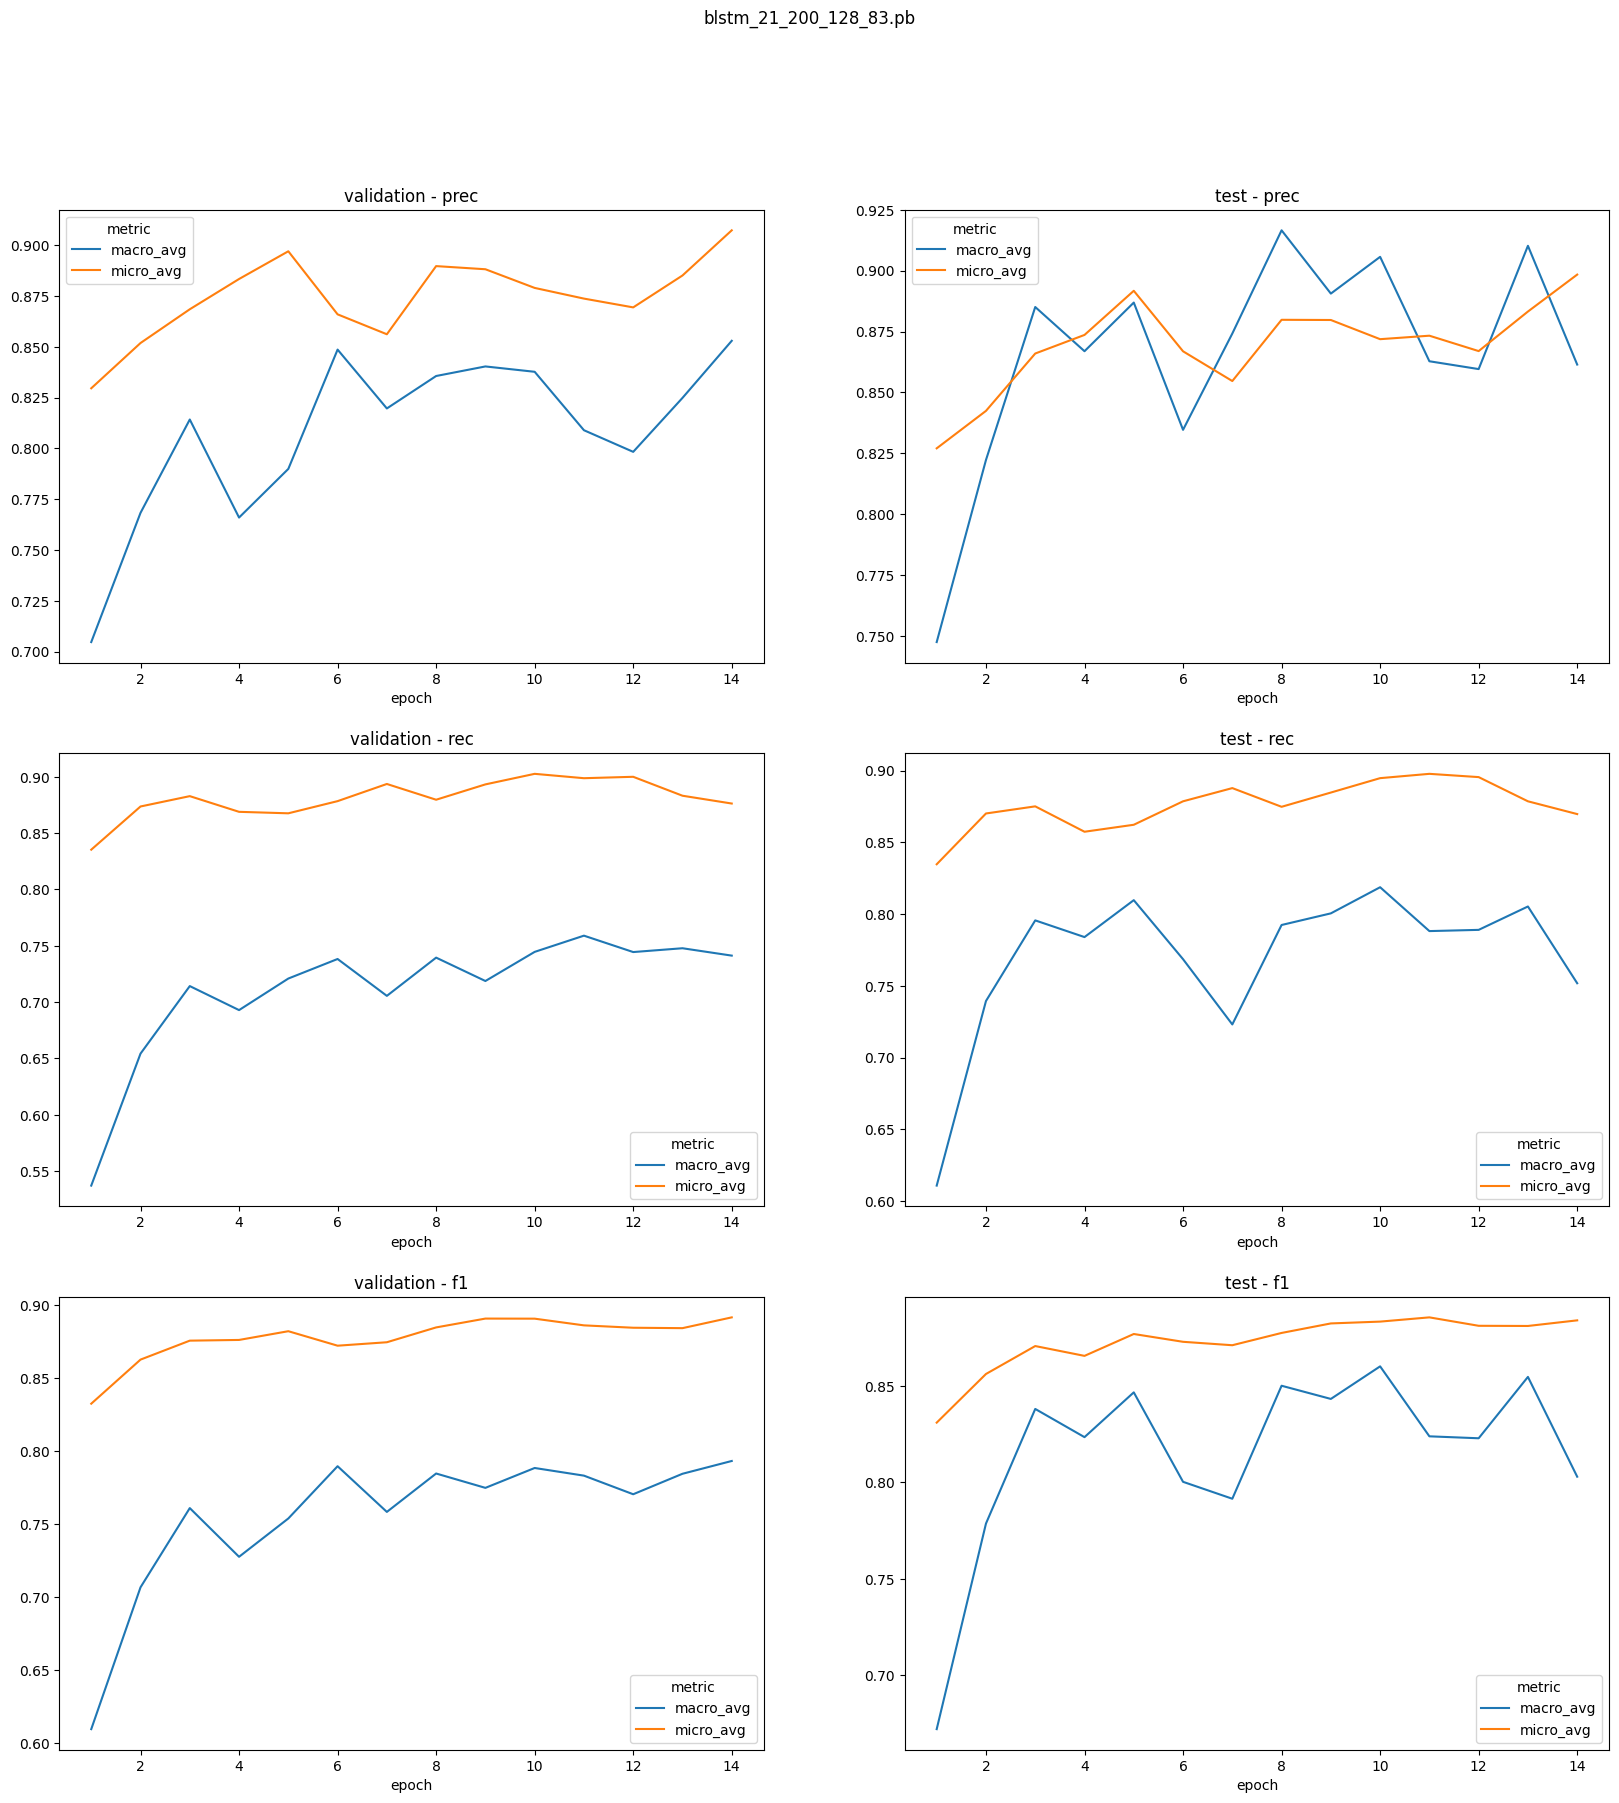

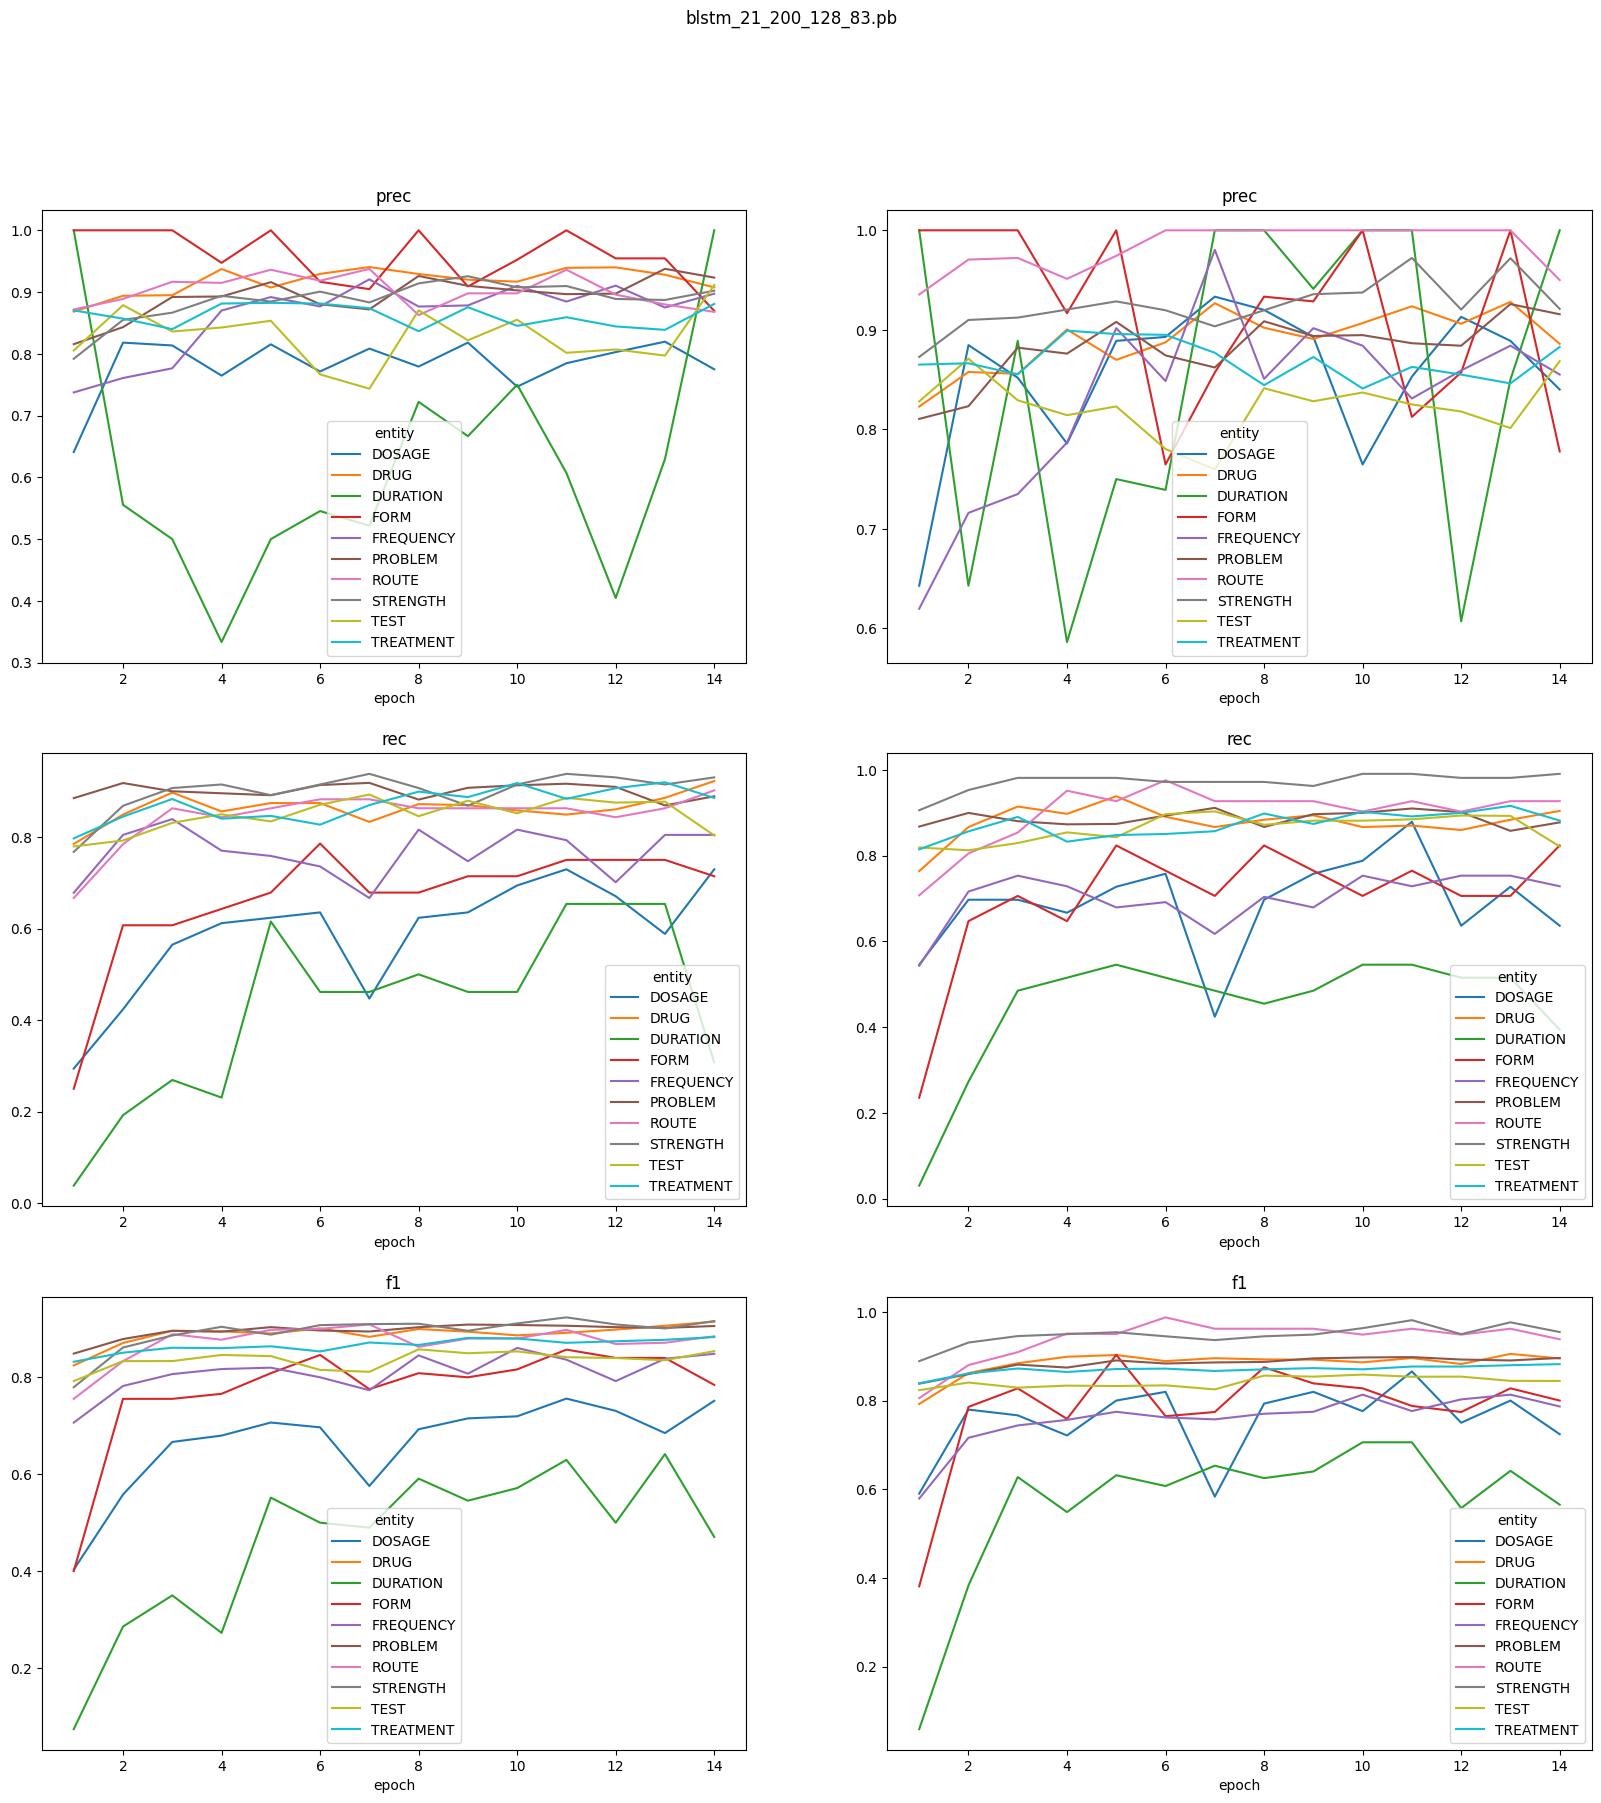

In [40]:
# to generate charts from the log file
# visualizing metrics like precision, recall, and F1-score across epochs.
log_file_path = "/content/ner_logs/MedicalNerApproach_974ff3998dce.log"  # Path to your log file
ner_log_parser.get_charts(log_file_path)

## Plotting Loss

Plotting the change in loss with the number of epochs may help determine the number of epochs required for training.

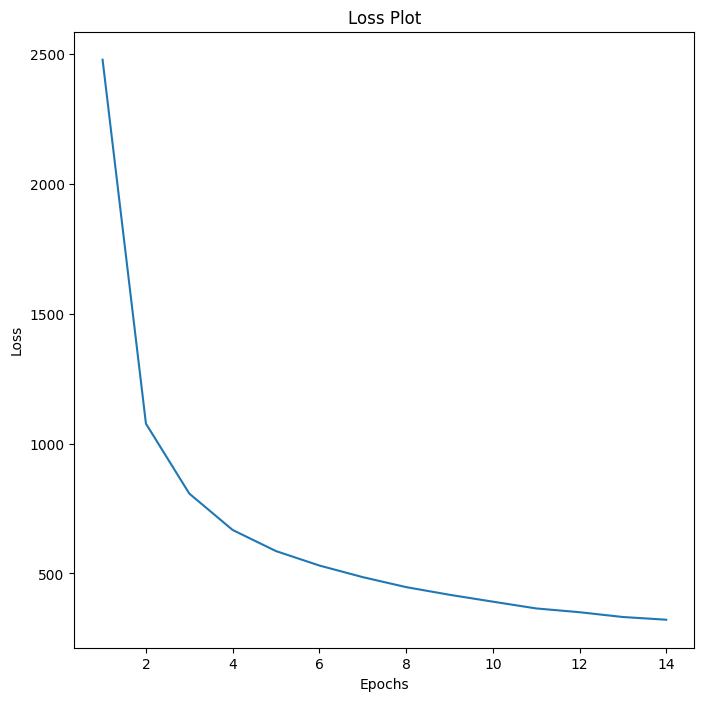

In [41]:

ner_log_parser.loss_plot(log_file_path)